<a href="https://colab.research.google.com/github/jamissonfreitas/IN1167/blob/master/ML/report_AM_2" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [0]:
from metricas import mape, mse, pocid

In [0]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [5]:
serie_name = 'star'
print('Série:', serie_name)
endereco = serie_name+'.txt'
dados = pd.read_csv(endereco, delimiter=' ', header=None)
serie = dados#[0]
minimo = 0
maximo = 1
scaler = MinMaxScaler(feature_range=(minimo, maximo))
scaler = scaler.fit(serie)
serie_normalizada = scaler.transform(serie)

Série: star


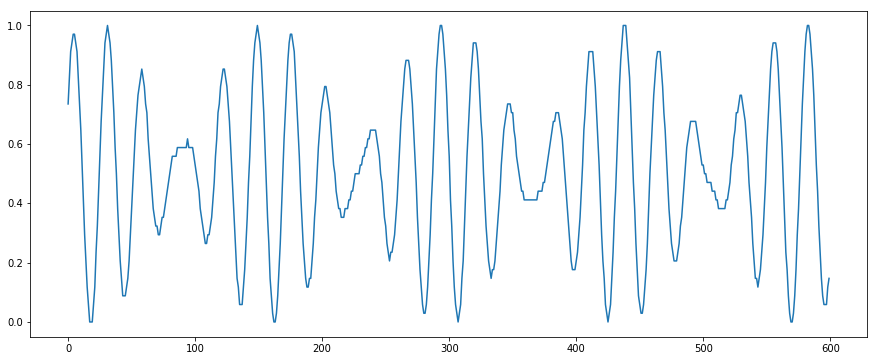

In [6]:
plt.plot(serie_normalizada)
plt.show()

In [0]:
def split_serie_with_lags(serie, perc_train, perc_val = 0):
    
    #faz corte na serie com as janelas já formadas 
    
    x_date = serie[:, 0:-1]
    y_date = serie[:, -1]        
       
    train_size = np.fix(len(serie) *perc_train)
    train_size = train_size.astype(int)
    
    if perc_val > 0:        
        val_size = np.fix(len(serie) *perc_val).astype(int)
              
        
        x_train = x_date[0:train_size,:]
        y_train = y_date[0:train_size]
        print("Particao de Treinamento:", 0, train_size  )
        
        x_val = x_date[train_size:train_size+val_size,:]
        y_val = y_date[train_size:train_size+val_size]
        
        print("Particao de Validacao:",train_size, train_size+val_size)
        
        x_test = x_date[(train_size+val_size):-1,:]
        y_test = y_date[(train_size+val_size):-1]
        
        print("Particao de Teste:", train_size+val_size, len(y_date))
        
        return x_train, y_train, x_test, y_test, x_val, y_val
        
    else:
        
        x_train = x_date[0:train_size,:]
        y_train = y_date[0:train_size]

        x_test = x_date[train_size:-1,:]
        y_test = y_date[train_size:-1]

        return x_train, y_train, x_test, y_test

In [0]:
def select_lag_acf(serie, max_lag):
    from statsmodels.tsa.stattools import acf
    x = serie[0: max_lag+1]
    
    acf_x, confint = acf(serie, nlags=max_lag, alpha=.05, fft=False,
                             unbiased=False)
       
    limiar_superior = confint[:, 1] - acf_x
    limiar_inferior = confint[:, 0] - acf_x
    
    lags_selecionados = []
    
    for i in range(1, max_lag+1):

        
        if acf_x[i] >= limiar_superior[i] or acf_x[i] <= limiar_inferior[i]:
            lags_selecionados.append(i-1)  #-1 por conta que o lag 1 em python é o 0
    
    #caso nenhum lag seja selecionado, essa atividade de seleção para o gridsearch encontrar a melhor combinação de lags
    if len(lags_selecionados)==0:


        print('NENHUM LAG POR ACF')
        lags_selecionados = [i for i in range(max_lag)]

    print('LAGS', lags_selecionados)

    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    #inverte o valor dos lags para usar na lista de dados se os dados forem de ordem [t t+1 t+2 t+3]
    lags_selecionados = [max_lag - (i+1) for i in lags_selecionados]
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

    return lags_selecionados

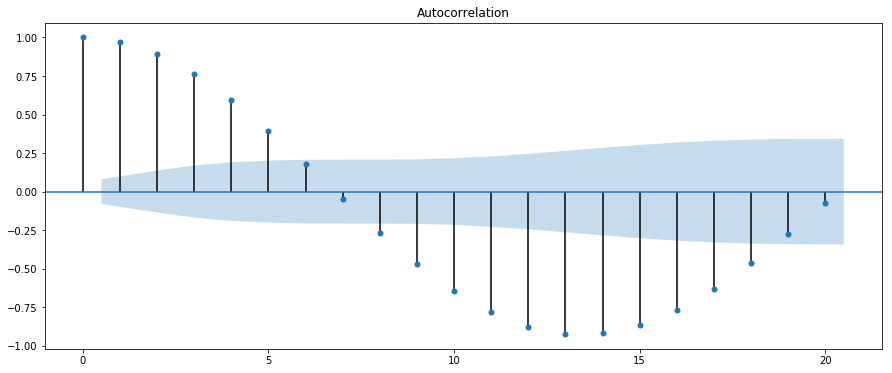

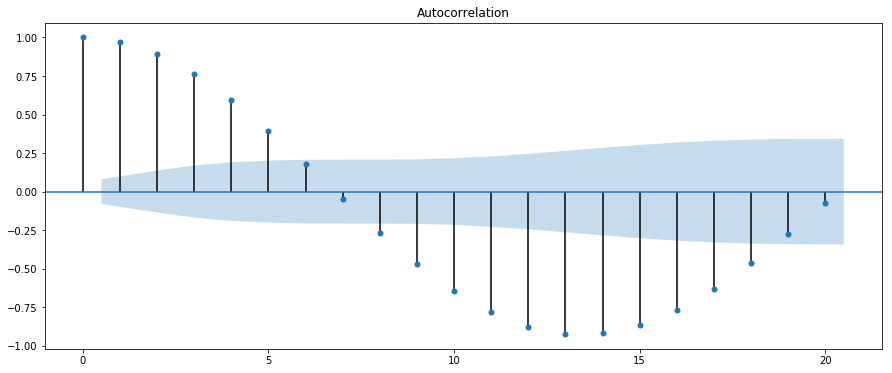

In [14]:
import statsmodels.api as sm

sm.graphics.tsa.plot_acf(serie_normalizada, lags=20)

In [0]:
def gerar_janelas(tam_janela, serie):
    # serie: vetor do tipo numpy ou lista
    tam_serie = len(serie)
    tam_janela = tam_janela +1 # Adicionado mais um ponto para retornar o target na janela
    
    janela = list(serie[0:0+tam_janela]) #primeira janela p criar o objeto np
    janelas_np = np.array(np.transpose(janela))    
       
    for i in range(1, tam_serie-tam_janela):
        janela = list(serie[i:i+tam_janela])
        j_np = np.array(np.transpose(janela))        
        
        janelas_np = np.vstack((janelas_np, j_np))
        
    
    return janelas_np

In [0]:
tam_janela = 20
serie_janelas = gerar_janelas(tam_janela, serie_normalizada)

In [17]:
x_train, y_train, x_test, y_test, x_val, y_val = split_serie_with_lags(serie_janelas, 0.50, perc_val = 0.25)

Particao de Treinamento: 0 289
Particao de Validacao: 289 433
Particao de Teste: 433 579


In [12]:
lags_acf = select_lag_acf(serie_normalizada, 20)

LAGS [0, 1, 2, 3, 4, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]


In [0]:
x_train = x_train[:,lags_acf]  #retorna só os lags selecionados no acf
x_val = x_val[:,lags_acf]
x_test = x_test[:,lags_acf]

In [0]:
def gerar_lstm(neuronios,  lags, func_opt='adam'):
    from keras.models import Sequential
    from keras.layers import LSTM, Dense

    model = Sequential()
    model.add(LSTM(neuronios, input_shape=(1, lags)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=func_opt)

    return model

In [0]:
def train_lstm(modelo, x_train, y_train, x_val, y_val, num_ex=5,epochs=100):
    
    trainX = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
    valX = np.reshape(x_val, (x_val.shape[0], 1, x_val.shape[1]))
    melhor_mse = np.Inf
    for i in range(0, num_ex):

        modelo.fit(trainX, y_train, epochs=epochs, batch_size=1, verbose=0)
        prev_v = modelo.predict(valX)
        novo_mse  = mse(y_val, prev_v)
        if novo_mse < melhor_mse:
            melhor_mse = novo_mse
            melhor_modelo = modelo

    return melhor_modelo, melhor_mse

In [0]:
def prev_lstm(modelo, x_test):
    testX = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
    y_prev = modelo.predict(testX)
    previsao = []
    for i in range(0, len(y_prev)):
        previsao.append(y_prev[i][0])


    return previsao

In [22]:
neuronios = [1, 10, 20, 50,  100]
func_opt = ['adam','sgd', 'rmsprop']
best_result = np.Inf

for i in range(0,len(neuronios)):
    for j in range(0,len(func_opt)):
        lstm = gerar_lstm(neuronios[i], len(lags_acf), func_opt = func_opt[j])
        lstm_treinada, mse_val = train_lstm(lstm, x_train, y_train, x_val, y_val, num_ex=1,epochs=50)
        if mse_val < best_result:
            best_result = mse_val
            select_model = lstm_treinada
            print('melhor configuração. neuronios:', neuronios[i], 'funcao:', func_opt[j])
        


Using TensorFlow backend.






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where








melhor configuração. neuronios: 1 funcao: adam


In [0]:
prev_test = prev_lstm(select_model, x_test)

In [24]:
pocid(y_test, prev_test)

77.77777777777779

In [25]:
mape(y_test, prev_test)

6.370270768467242

In [26]:
mse(y_test, prev_test)

0.0004082484240886155

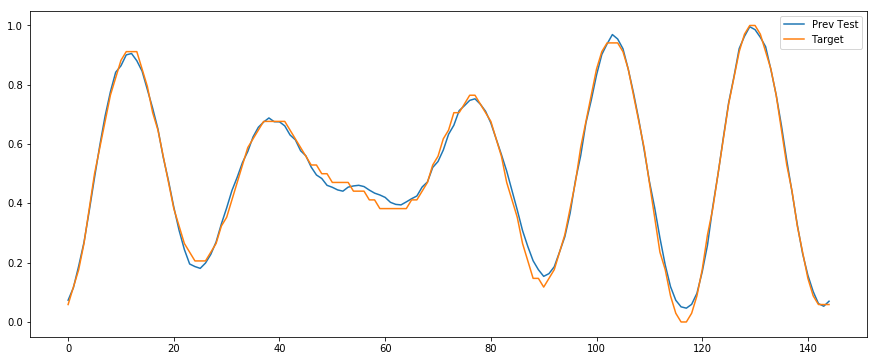

In [27]:
plt.plot(prev_test, label = 'Prev Test')
plt.plot(y_test, label='Target')
plt.legend(loc='best')
plt.show()

In [30]:
!pip install sklearn_extensions

  Created wheel for sklearn-extensions: filename=sklearn_extensions-0.0.2-py2.py3-none-any.whl size=24577 sha256=a0a3fea3e33733d3fd156329f2ae5c0b0957bcd20d715d3bfb0d55ef7476dfd0
  Stored in directory: /root/.cache/pip/wheels/b5/26/b2/09100728168b45e4de834b943a588028744fdfaa9ac979ffb2
Successfully built sklearn-extensions


In [0]:
import numpy as np
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn_extensions.extreme_learning_machines.elm import ELMRegressor
from sklearn_extensions.extreme_learning_machines.random_layer import RBFRandomLayer, MLPRandomLayer

In [0]:
def train_elm(modelo, x_train, y_train, x_val, y_val, num_ex=5):
    
    trainX = x_train # np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
    valX = x_val # np.reshape(x_val, (x_val.shape[0], 1, x_val.shape[1]))
    melhor_mse = np.Inf
    
    for i in range(0, num_ex):
        modelo.fit(trainX, y_train)
        prev_v = modelo.predict(valX)
        novo_mse  = mse(y_val, prev_v)
        if novo_mse < melhor_mse:
            melhor_mse = novo_mse
            melhor_modelo = modelo

    return melhor_modelo, melhor_mse

In [54]:
neuronios = [2, 10, 20, 50,  100]
func_opt = ['adam','sgd', 'rmsprop']
best_result = np.Inf

for i in range(0,len(neuronios)):
    for j in range(0,len(func_opt)):
        elm = ELMRegressor(n_hidden=i), activation_func=j)
        elm_treinada, mse_val = train_elm(elm, x_train, y_train, x_val, y_val, num_ex=1)
        if mse_val < best_result:
            best_result = mse_val
            select_model = lstm_treinada
            print('melhor configuração. neuronios:', neuronios[i], 'funcao:', func_opt[j])

KeyError: ignored

In [44]:
y_train[0]


0.058823529411764705